**Title:** Influence of Land Use Policy on Carbon Emissions in Canada

**Introduction:** Canada has made a national priority to comply with its commitment regarding the reduction of carbon emissions while climate change effects emerge as a critical global concern. Land use policy has been identified by scholars as a one of the main factors inflecting carbon emissions. As Canada has been undergoing huge geographical changes in the last three decades, we aim to study the influence of land use variations on Canada’s and Provinces’ carbon emissions in order to assess the potential impact of various land use policy changes.

**Dataset:** We will use the "Carbon Emissions of Canada and Provinces for the Last 30 Years" dataset, whose the terms of utilisation fall under the Open Government License Canada (https://open.canada.ca/en/open-government-licence-canada). 

**Preliminary Exploratory Data Analysis:** We will be using R for our analysis. We wrangled the data by using pivot_wider and renaming several columns in order to make the datatset tidy. We are going to focus primarily  on carbon emissions variables, carbon emissions by economic sectors, and land use data, surely getting rid of columns such as “meaurements units”, “sub-sectors” or the gas times informations. To conduct exploratory data analysis, we will create visualizations, such as line plots ('geom_lines') and smoothed trendlines ('geom_smooth') to understand historical trends in emissions and the relationship between land use policy and emissions.

**Methods:** We will use regression modeling (k-algorithm) trained on historical data since 1990 to predict future emissions based, therefore showing the possible impact of land-use policies on carbon emissions. To reach this goal, we will nead to create a new tibble showing the relations between land use (data stored in the file : “EN_Ch6_Tables_FullTimeSeries” accessible on the Canada government website) and carbon emission. We may also consider time-series analysis to capture temporal patterns in emissions data. Visualizations will be used to effectively communicate our results.

**Expected Outcomes and Significance:** We expect that our analysis will show the significant influence of land use policies on carbon emissions in Canadian provinces over the past 30 years. By predicting future emissions, we anticipate to assess the potential impact of different land use policies, highlighting the importance of sustainable land management, such as preserving wetlands and forests. Moreover, our analysis may entail further questions about the impact of carbon emissions on the socio-economic effects of these land changes, especially those impacting indigenous communities. Studying the impact of land use policies on carbon emissions in Canadian provinces and its potential consequences could actually be a small contribution to addressing the climate change challenge.


In [1]:
library(repr)
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
url <- "https://data-donnees.az.ec.gc.ca/api/file?path=/substances/monitor/canada-s-official-greenhouse-gas-inventory/B-Economic-Sector/EN_GHG_Econ_Can_Prov_Terr.csv"
data <- read.csv(url)

In [3]:
data$CO2eq <- as.numeric(data$CO2eq)
data$Year <- as.integer(data$Year)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [4]:
total_per_province <- data |>
  filter(Source %in% c("Provincial Inventory Total", "Territorial Inventory Total", "National Inventory Total")) |>
  filter(Region != "Canada", Region != "Northwest Territories and Nunavut") |>
  na.omit(cols = c("Year", "CO2eq")) |>
  select(year, Region, Source, CO2eq)

total_per_province

,Year,Region,Index,Source,Sector,Sub.sector,Sub.sub.sector,Total,CO2eq,Unit
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1990,Newfoundland and Labrador,0,Provincial Inventory Total,,,,y,9.4112435,Mt
2,1990,Prince Edward Island,0,Provincial Inventory Total,,,,y,1.7695610,Mt
3,1990,Nova Scotia,0,Provincial Inventory Total,,,,y,19.3475232,Mt
4,1990,New Brunswick,0,Provincial Inventory Total,,,,y,16.0758812,Mt
5,1990,Quebec,0,Provincial Inventory Total,,,,y,84.2979794,Mt
6,1990,Ontario,0,Provincial Inventory Total,,,,y,179.1267395,Mt
7,1990,Manitoba,0,Provincial Inventory Total,,,,y,18.0424879,Mt
8,1990,Saskatchewan,0,Provincial Inventory Total,,,,y,42.4673547,Mt
9,1990,Alberta,0,Provincial Inventory Total,,,,y,165.4817753,Mt


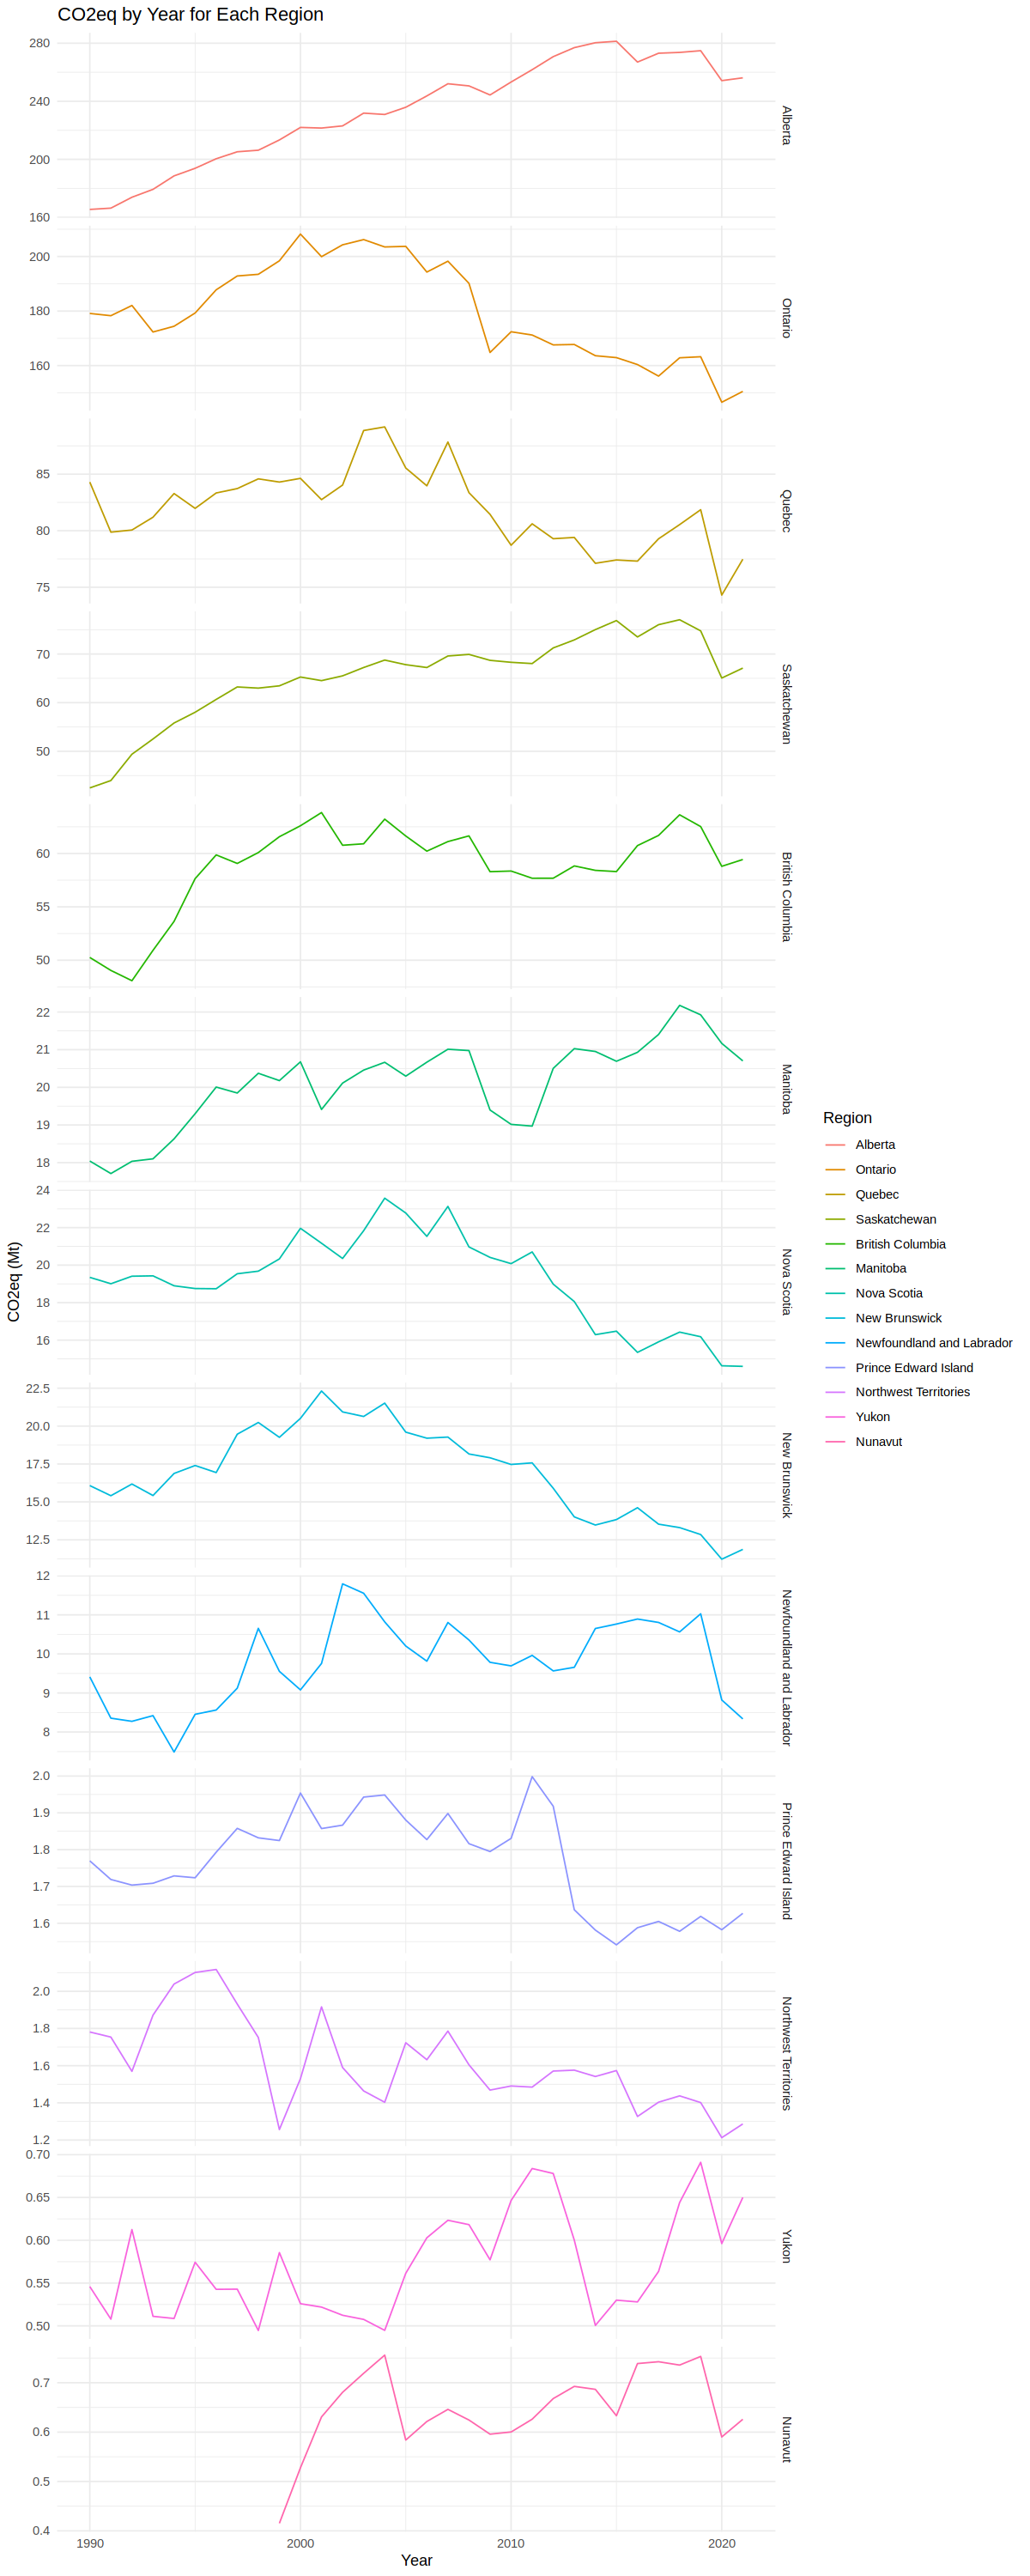

In [5]:
total_emissions <- filtered_data |>
  group_by(Region) |>
  summarize(TotalEmissions = sum(CO2eq, na.rm = TRUE))

filtered_data$Region <- factor(filtered_data$Region, levels = total_emissions$Region[order(-total_emissions$TotalEmissions)])

options(repr.plot.width = 10, repr.plot.height = 25)
ggplot(filtered_data, aes(x = Year, y = CO2eq, group = Region, color = Region)) + 
  geom_line() +
  theme_minimal() +
  labs(title = "CO2eq by Year for Each Region",
       x = "Year",
       y = "CO2eq (Mt)") +
  facet_grid(Region ~ ., scales = "free_y")
